In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from autoencoders import TFVariationalAutoencoder
import pandas as pd
import random


c:\Users\eguen\miniconda3\envs\vae_env\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\eguen\miniconda3\envs\vae_env\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\eguen\miniconda3\envs\vae_env\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\eguen\miniconda3\envs\vae_env\lib\site-packages\tensorf


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Hiperparametros

In [231]:
# select data source:
# can be "mill" or "X"
# data_source = "C:/Users/eguen/Documents/IFAC-VAE-Imputation/X"

# # select corruption level:
# # can be "light" or "heavy"
# corr_level = "light"

# # Path to uncorrupted data:
# DataPath = data_source + "data.csv"
# # Path to corrupted data:
# CorruptDataPath = data_source + "datacorrupt" + corr_level + ".csv"
CorruptDataPath = r"C:\Users\eguen\Documents\Smart Energy Technologies\combined_cleaned_data.csv"

# VAE network size:
Decoder_hidden1 = 20
Decoder_hidden2 = 20
Encoder_hidden1 = 20
Encoder_hidden2 = 20

# dimensionality of latent space:
latent_size = 5

# training parameters:
training_epochs = 500
batch_size = 250
learning_rate = 0.0001

# specify number of imputation iterations:
ImputeIter = 25

# Carga de datos

In [232]:
# Cargar datos con valores faltantes:
Xdata_df = pd.read_csv(CorruptDataPath)
Xdata_df.replace(0, np.nan, inplace=True)
# Asegurar que todos los valores sean numéricos
Xdata_df = Xdata_df.apply(pd.to_numeric, errors='coerce')
Xdata_df = Xdata_df.transpose()
Xdata_df.columns = Xdata_df.iloc[0]
Xdata_df = Xdata_df.drop(index="NIC")
Xdata_Missing = Xdata_df.values
del Xdata_df

# Propiedades de los datos:
Xdata_length = Xdata_Missing.shape[0] # número de puntos de datos
n_x = Xdata_Missing.shape[1] # dimensionalidad del espacio de datos
ObsRowInd = np.where(np.isfinite(np.sum(Xdata_Missing, axis=1)))
NanRowInd = np.where(np.isnan(np.sum(Xdata_Missing, axis=1)))
NanIndex = np.where(np.isnan(Xdata_Missing))
Xdata_Missing_Rows = NanRowInd[0] # filas con valores faltantes

# Número de valores faltantes:
NanCount = len(NanIndex[0])

In [233]:
# Cargar datos con valores faltantes:
Xdata_df = pd.read_csv(CorruptDataPath)
Xdata_df = Xdata_df.apply(pd.to_numeric, errors='coerce')
Xdata_df = Xdata_df.transpose()
Xdata_df.columns = Xdata_df.iloc[0]
Xdata_df = Xdata_df.drop(index="NIC")
Xdata=Xdata_df.values
del Xdata_df
Xdata.astype(np.float32)  

array([[ 69823.27 ,  84229.82 ,  92301.734, ...,  56815.   , 264042.56 ,
        684354.44 ],
       [ 69834.54 ,  84229.83 ,  92350.43 , ...,  56831.8  , 264087.97 ,
        684354.44 ],
       [ 69848.05 ,  84229.836,  92398.95 , ...,  56852.44 , 264134.75 ,
        684354.44 ],
       ...,
       [ 83921.81 ,  91400.73 , 135905.16 , ...,  73128.78 , 293040.78 ,
        614201.   ],
       [ 83940.58 ,  91424.19 , 135959.66 , ...,  73153.04 , 293106.72 ,
        618734.94 ],
       [ 83955.516,  91454.05 , 136030.86 , ...,  73171.164, 293179.78 ,
        623202.9  ]], dtype=float32)

In [234]:
Xdata[:][0]

array([6.98232713e+04, 8.42298200e+04, 9.23017312e+04, 5.69083775e+04,
                  nan,            nan,            nan,            nan,
       1.93675000e+01, 1.89553160e+05, 2.63249325e+05, 3.32768750e+01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.52788250e+03,
       1.93652125e+04, 9.44368140e+05, 1.16101938e+05, 4.00452856e+04,
       3.23177720e+05, 1.46498656e+04, 2.43273720e+05, 4.50346820e+05,
       9.92022287e+04, 4.97791494e+04, 1.14427143e+05, 2.69563535e+05,
       4.43311563e+03, 6.35236562e+04, 1.88766365e+05, 7.83652563e+04,
       1.07429038e+05, 4.57088069e+04, 1.44243750e+01, 1.53506653e+05,
       1.75314188e+03, 3.19188920e+05, 1.45795513e+05, 5.89510600e+04,
       3.51796859e+05, 3.66181250e+01, 6.68450000e+01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.05843750e+01,
       9.48312500e+00, 4.43161220e+05, 5.68150000e+04, 2.64042575e+05,
      

In [235]:
# Normalizar los datos para la imputación:
# sc = StandardScaler()
# Xdata_Missing_complete = np.copy(Xdata_Missing[ObsRowInd[0],:])
# sc.fit(Xdata_Missing_complete)
# Xdata_Missing[NanIndex] = 0
# Xdata_Missing = sc.transform(Xdata_Missing)
# Xdata_Missing[NanIndex] = np.nan
# del Xdata_Missing_complete

# Ajustar StandardScaler solo con las columnas que tienen valores no faltantes
sc = StandardScaler()

# Imputar valores faltantes con ceros
Xdata_Missing_filled = np.copy(Xdata_Missing)
Xdata_Missing_filled[NanIndex] = 0

# Ajustar el StandardScaler con datos imputados
sc.fit(Xdata_Missing_filled)
Xdata_Missing = sc.transform(Xdata_Missing_filled)

def next_batch(Xdata, batch_size, MissingVals=False):
    """ Muestra aleatoriamente batch_size elementos de la matriz de datos, Xdata.
        Xdata es una matriz [NxM], N observaciones de M variables.
        batch_size debe ser menor que N.
        
        Devuelve Xdata_sample, una matriz [batch_size x M].
    """
    if MissingVals:
        Xdata_length = Xdata.shape[0]
        X_indices = random.sample(range(Xdata_length), batch_size)
        Xdata_sample = np.copy(Xdata[X_indices, :])
        NanIndex = np.where(np.isnan(Xdata_sample))
        Xdata_sample[NanIndex] = 0
    else:
        ObsRowIndex = np.where(np.isfinite(np.sum(Xdata, axis=1)))
        X_indices = random.sample(list(ObsRowIndex[0]), batch_size)
        Xdata_sample = np.copy(Xdata[X_indices, :])
    
    return Xdata_sample

In [236]:
Xdata_Missing.shape

(852, 57)

# Entrenamiento VAE

c:\Users\eguen\miniconda3\envs\vae_env\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 1.0000 Cost= 111.109760446
Epoch: 11.0000 Cost= 87.334711227
Epoch: 21.0000 Cost= 100.061096496
Epoch: 31.0000 Cost= 87.301281137
Epoch: 41.0000 Cost= 79.321514273
Epoch: 51.0000 Cost= 80.474040878
Epoch: 61.0000 Cost= 79.045318102
Epoch: 71.0000 Cost= 75.029738072
Epoch: 81.0000 Cost= 73.164859288
Epoch: 91.0000 Cost= 72.230580827
Epoch: 101.0000 Cost= 71.722713435
Epoch: 111.0000 Cost= 72.637754987
Epoch: 121.0000 Cost= 71.596515011
Epoch: 131.0000 Cost= 71.164238621
Epoch: 141.0000 Cost= 69.545481686
Epoch: 151.0000 Cost= 68.718211752
Epoch: 161.0000 Cost= 68.725550119
Epoch: 171.0000 Cost= 67.478119487
Epoch: 181.0000 Cost= 67.382469983
Epoch: 191.0000 Cost= 66.264501760
Epoch: 201.0000 Cost= 64.834055207
Epoch: 211.0000 Cost= 63.048664953
Epoch: 221.0000 Cost= 62.126867088
Epoch: 231.0000 Cost= 59.343492481
Epoch: 241.0000 Cost= 56.288329648
Epoch: 251.0000 Cost= 55.922460108
Epoch: 261.0000 Cost= 53.301721671
Epoch: 271.0000 Cost= 51.065310626
Epoch: 281.0000 Cost= 49.3247

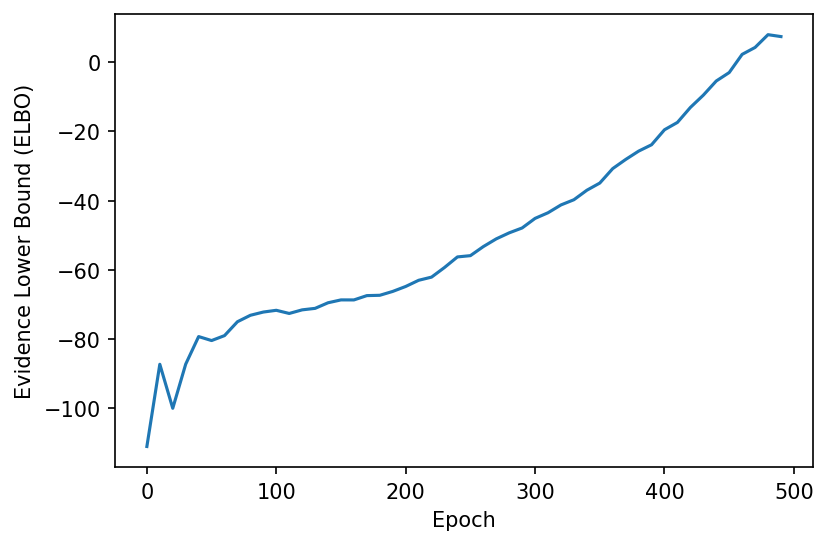

In [237]:
# Definir diccionario para la estructura de la red:
network_architecture = {
    'n_hidden_recog_1': Encoder_hidden1,  # neuronas de la 1ª capa del codificador
    'n_hidden_recog_2': Encoder_hidden2,  # neuronas de la 2ª capa del codificador
    'n_hidden_gener_1': Decoder_hidden1,  # neuronas de la 1ª capa del decodificador
    'n_hidden_gener_2': Decoder_hidden2,  # neuronas de la 2ª capa del decodificador
    'n_input': n_x,  # tamaño de la entrada de datos
    'n_z': latent_size  # dimensionalidad del espacio latente
}

# Inicializar VAE:
vae = TFVariationalAutoencoder(network_architecture, learning_rate=learning_rate, batch_size=batch_size)

# Entrenar VAE en los datos corruptos:
vae = vae.train(XData=Xdata_Missing, training_epochs=training_epochs)

# Graficar historial de entrenamiento:
fig = plt.figure(dpi=150)
plt.plot(vae.losshistory_epoch, vae.losshistory)
plt.xlabel('Epoch')
plt.ylabel('Evidence Lower Bound (ELBO)')
plt.show()

# Imputacion de valores faltantes

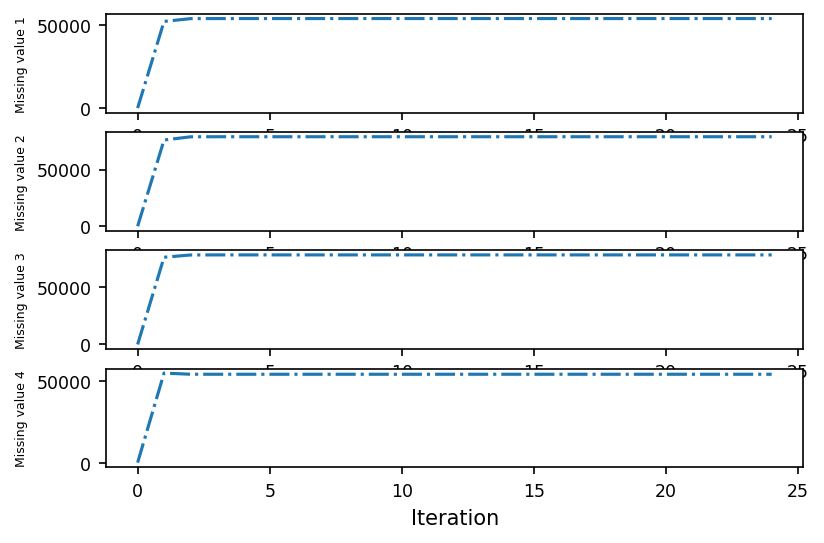

Reconstruction error (VAE): nan


In [238]:
# Imputar valores faltantes:
# X_impute = vae.impute(X_corrupt=Xdata_Missing, max_iter=ImputeIter)
X_impute = vae.impute(X_corrupt=Xdata, max_iter=ImputeIter)

# Graficar resultados de la imputación para valores de muestra:
fig = plt.figure(dpi=150)
subplotmax = min(NanCount, 4)
for plotnum in range(subplotmax):
    plt.subplot(subplotmax, 1, plotnum+1)
    plt.plot(range(ImputeIter), vae.MissVal[:, plotnum], '-.')
    plt.xlabel('Iteration')
    plt.ylabel(f'Missing value {plotnum+1}', fontsize=6)
    plt.tick_params(labelsize='small')
plt.show()

# Normalizar Xdata_Missing e imputar Xdata:
X_impute = sc.inverse_transform(X_impute)
# ReconstructionError = sum(((X_impute[NanIndex] - Xdata[NanIndex])**2)**0.5)/NanCount
# Calcular y mostrar el error de reconstrucción:
ReconstructionError = sum(((X_impute[NanIndex] - Xdata_Missing[NanIndex])**2)**0.5) / NanCount
print('Reconstruction error (VAE):', ReconstructionError)

In [239]:
Xdata[:][0]

array([6.98232713e+04, 8.42298200e+04, 9.23017312e+04, 5.69083775e+04,
       5.38640820e+04, 7.88661172e+04, 7.79366406e+04, 5.42879102e+04,
       1.93675000e+01, 1.89553160e+05, 2.63249325e+05, 3.32768750e+01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.52788250e+03,
       1.93652125e+04, 9.44368140e+05, 1.16101938e+05, 4.00452856e+04,
       3.23177720e+05, 1.46498656e+04, 2.43273720e+05, 4.50346820e+05,
       9.92022287e+04, 4.97791494e+04, 1.14427143e+05, 2.69563535e+05,
       4.43311563e+03, 6.35236562e+04, 1.88766365e+05, 7.83652563e+04,
       1.07429038e+05, 4.57088069e+04, 1.44243750e+01, 1.53506653e+05,
       1.75314188e+03, 3.19188920e+05, 1.45795513e+05, 5.89510600e+04,
       3.51796859e+05, 3.66181250e+01, 6.68450000e+01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.05843750e+01,
       9.48312500e+00, 4.43161220e+05, 5.68150000e+04, 2.64042575e+05,
      

In [240]:
X_impute[:][0]

array([2.69259749e+09, 3.72254205e+09, 5.33182839e+09, 1.96145813e+09,
       1.23125969e+09, 1.58809737e+09, 4.88483684e+09, 4.24179952e+09,
       9.47770695e+06, 2.00124109e+10, 3.58721113e+10, 6.07347002e+02,
       1.36873137e+05, 1.87075822e+04, 1.74437297e+04, 1.40671853e+05,
       4.86738144e+04, 8.87060947e+04, 4.74448164e+04, 3.84023289e+08,
       4.88205180e+08, 3.06569311e+11, 6.66592419e+09, 1.12332736e+09,
       4.42004574e+10, 1.06581183e+08, 3.15092329e+10, 1.12169418e+11,
       5.52622511e+09, 1.34663427e+09, 6.72258717e+09, 3.67198277e+10,
       1.06556263e+07, 2.16015619e+09, 1.91735620e+10, 3.45911326e+09,
       6.99291650e+09, 1.19483288e+09, 1.36743354e+02, 1.32895373e+10,
       1.52821079e+06, 5.59501178e+10, 1.19017355e+10, 2.16933875e+09,
       7.32910007e+10, 7.35319887e+02, 2.60197258e+03, 7.84763104e+03,
       1.70661953e+03, 1.92962165e+04, 4.00196204e+03, 5.05162549e+02,
       5.64331189e+01, 1.06226842e+11, 1.73783743e+09, 3.47817723e+10,
      

# Generar Valores e histogramas

In [70]:
Xdata_Missing.shape

(852, 57)

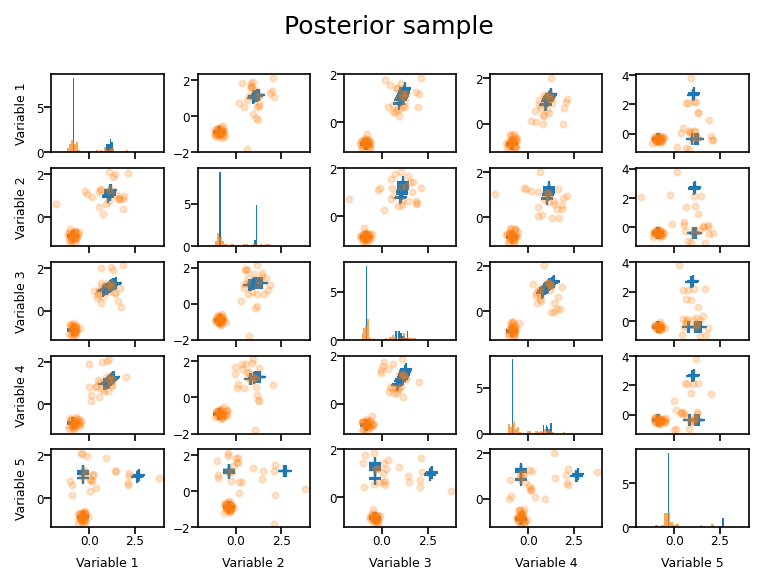

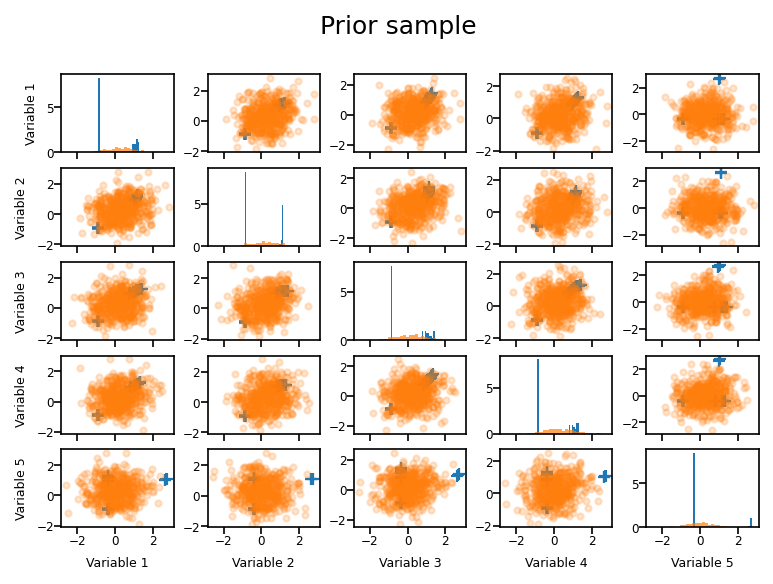

In [71]:
# Reconstruir datos mediante muestreo de la distribución de variables reconstruidas:
np_x = next_batch(Xdata_Missing, 57)
x_hat = vae.reconstruct(np_x, sample='sample')

x_hat_prior = vae.generate(n_samples=500)
x_hat_prior = x_hat_prior.eval()

subplotmax = min(n_x, 5)
f, axarr = plt.subplots(subplotmax, subplotmax, sharex='col', dpi=150)
f.suptitle('Posterior sample')
f.subplots_adjust(wspace=0.3)
for k in range(subplotmax):
    for j in range(subplotmax):
        if k == j:
            axarr[k, j].hist(np_x[:, k], bins=30, density=True)
            axarr[k, j].hist(x_hat[:, k], bins=30, alpha=0.7, density=True)
            axarr[k, j].tick_params(labelsize='xx-small', pad=0)
            if j == 0:
                axarr[k, j].set_ylabel(f'Variable {k+1}', fontsize=6)
            elif j == subplotmax-1:
                axarr[k, j].set_xlabel(f'Variable {subplotmax}', fontsize=6)
        else:
            axarr[k, j].plot(np_x[:, k], np_x[:, j], '+', label='Data')
            axarr[k, j].plot(x_hat[:, k], x_hat[:, j], '.', alpha=0.2, label='Posterior')
            axarr[k, j].tick_params(labelsize='xx-small', pad=0)
            if j == 0:
                axarr[k, j].set_ylabel(f'Variable {k+1}', fontsize=6)
            if k == subplotmax-1:
                axarr[k, j].set_xlabel(f'Variable {j+1}', fontsize=6)

f, axarr = plt.subplots(subplotmax, subplotmax, sharex='col', dpi=150)
f.suptitle('Prior sample')
f.subplots_adjust(wspace=0.3)
for k in range(subplotmax):
    for j in range(subplotmax):
        if k == j:
            axarr[k, j].hist(np_x[:, k], bins=30, density=True)
            axarr[k, j].hist(x_hat_prior[:, k], bins=30, alpha=0.7, density=True)
            axarr[k, j].tick_params(labelsize='xx-small', pad=0)
            if j == 0:
                axarr[k, j].set_ylabel(f'Variable {k+1}', fontsize=6)
            elif j == subplotmax-1:
                axarr[k, j].set_xlabel(f'Variable {subplotmax}', fontsize=6)
        else:
            axarr[k, j].plot(np_x[:, k], np_x[:, j], '+', label='Data')
            axarr[k, j].plot(x_hat_prior[:, k], x_hat_prior[:, j], '.', alpha=0.2, label='Prior')
            axarr[k, j].tick_params(labelsize='xx-small', pad=0)
            if j == 0:
                axarr[k, j].set_ylabel(f'Variable {k+1}', fontsize=6)
            if k == subplotmax-1:
                axarr[k, j].set_xlabel(f'Variable {j+1}', fontsize=6)

vae.sess.close()